# Advance Lane Lines Project

This jupyter notebook contains all of the code used in the implementation of the Advance Lane Lines project. The purpose of this project is to correctly identify lanes on a road and their curvature. This is essential information for self-driving cars when calculating steering angles. 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

We will use this first cell to go ahead and import all of the libraries that we will need throughout this project. 

In [39]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

The output of this project will be a video with the detected lanes overlaid. The next cell shows the first frame of the input video. We will apply our pipeline to identify lanes to each frame. We will use this first frame as an example throughout the notebook to illustrate what the pipeline is doing. 


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


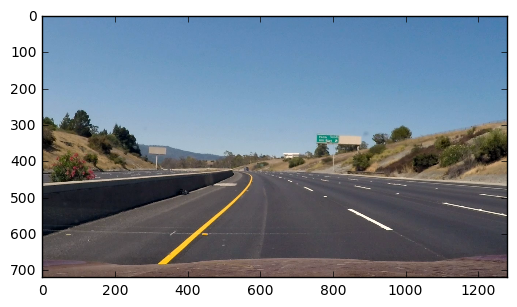

In [40]:
vidcap = cv2.VideoCapture('project_video.mp4')
success,frame1 = vidcap.read()
count = 0
success = True

plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
print('This image is:', type(frame1), 'with dimesions:', frame1.shape)
cv2.imwrite("output_images/frame1.jpg", frame1);

## Camera Calibration
---

The purpose of calibrating the camera is to later undistort the image. To calibrate the camera we will use a function provided by OpenCV. 


**`cv2.calibrateCamera(objp, imgp, img_size, None, None)`**

This function takes in objectPoints and imagePoints as the first two parameters. Each of these is a vector of vectors of calibration pattern points in the calibration pattern coordinate space. For further information look at the [OpenCV documentation](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

To obtain the objectPoints and imagePoints we will use the finding chessboard corners technique implemented in the next couple of cells. The image points are returned by the **`findChessboardCorners`** function also from OpenCV.

In [41]:
# checkerboard Dimensions
cbrow = 6
cbcol = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((cbrow * cbcol, 3), np.float32)
objp[:, :2] = np.mgrid[0:cbcol, 0:cbrow].T.reshape(-1, 2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (cbcol, cbrow), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

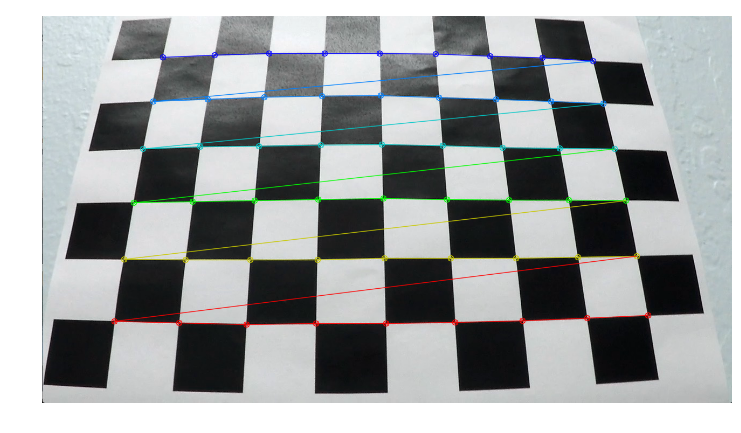

In [42]:
# Lets print one example of the found corners
img = cv2.imread("camera_cal/calibration3.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
cv2.drawChessboardCorners(img, (9, 6), corners, ret)

plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off");
cv2.imwrite("output_images/chessboard_corners.jpg", img);

The output of the cell above shows the corners found by `findChessboardCorners` overlaid on the original image. This calculation is done for all of the calibration images in the `camera_cal` folder.


## Distortion Correction
---

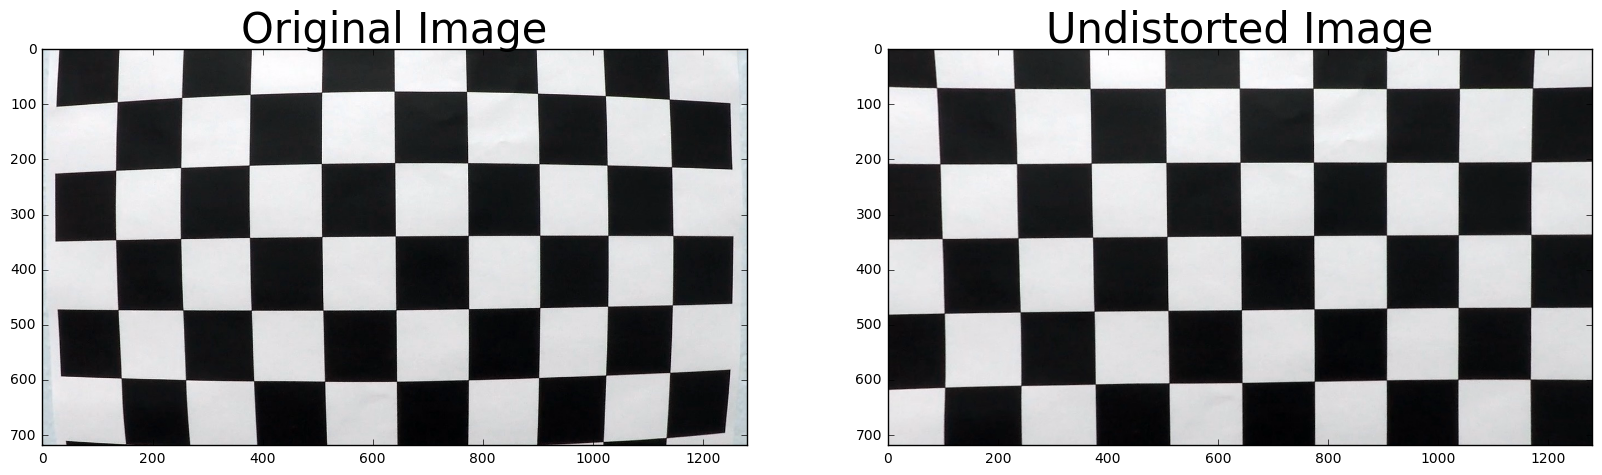

In [43]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite("output_images/chessboard_undistorted.jpg", dst);

Above we see how one of the chessboard images used to calibrate the camera is affected by distortion. Now lets see how the camera calibration and image undistortion affects our first fame.

For the sake of keeping everything organized and readable we will use a helper function in future occasions. 

In [44]:
def undistort_image(img, objp, imgp):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

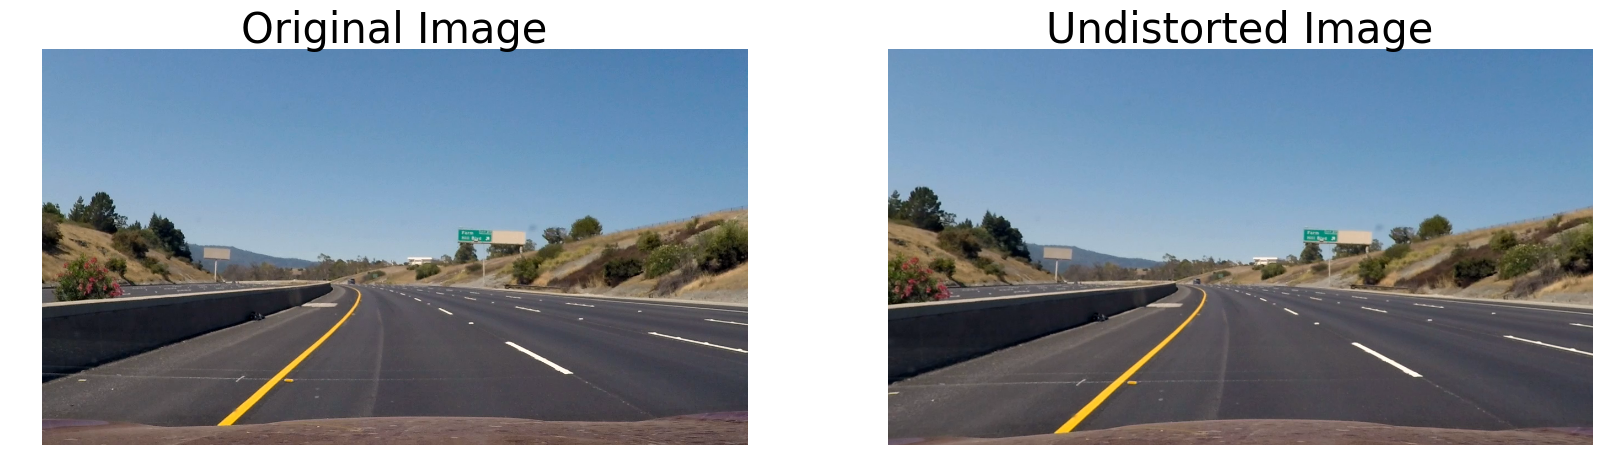

In [45]:
# Test undistortion on an image
test_img = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame1_undistorted = test_dst = undistort_image(test_img, objpoints, imgpoints)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title('Original Image', fontsize=30)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(test_dst)
plt.title('Undistorted Image', fontsize=30);
plt.axis("off")
cv2.imwrite("output_images/frame1_undistorted.jpg", test_dst);

At first glance it is hard not notice the changes, but upon further inspection we notice that the edges are quite different. The most notable changes are the location of the vegetation on the left and the hood of the car at the bottom of the image. 

## Gradient Threshold
---

There are some algorithms which are useful for edge detection. The the following cells we will implement and compare 3 of them. Later on we will use a combination of gradient and color threshold to identify lanes. 

In [46]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):    
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In the previous cell we defined function for Sobel, Magnitude, and Direction thresholds. In the next one we will visualize the results of running and image through each one.

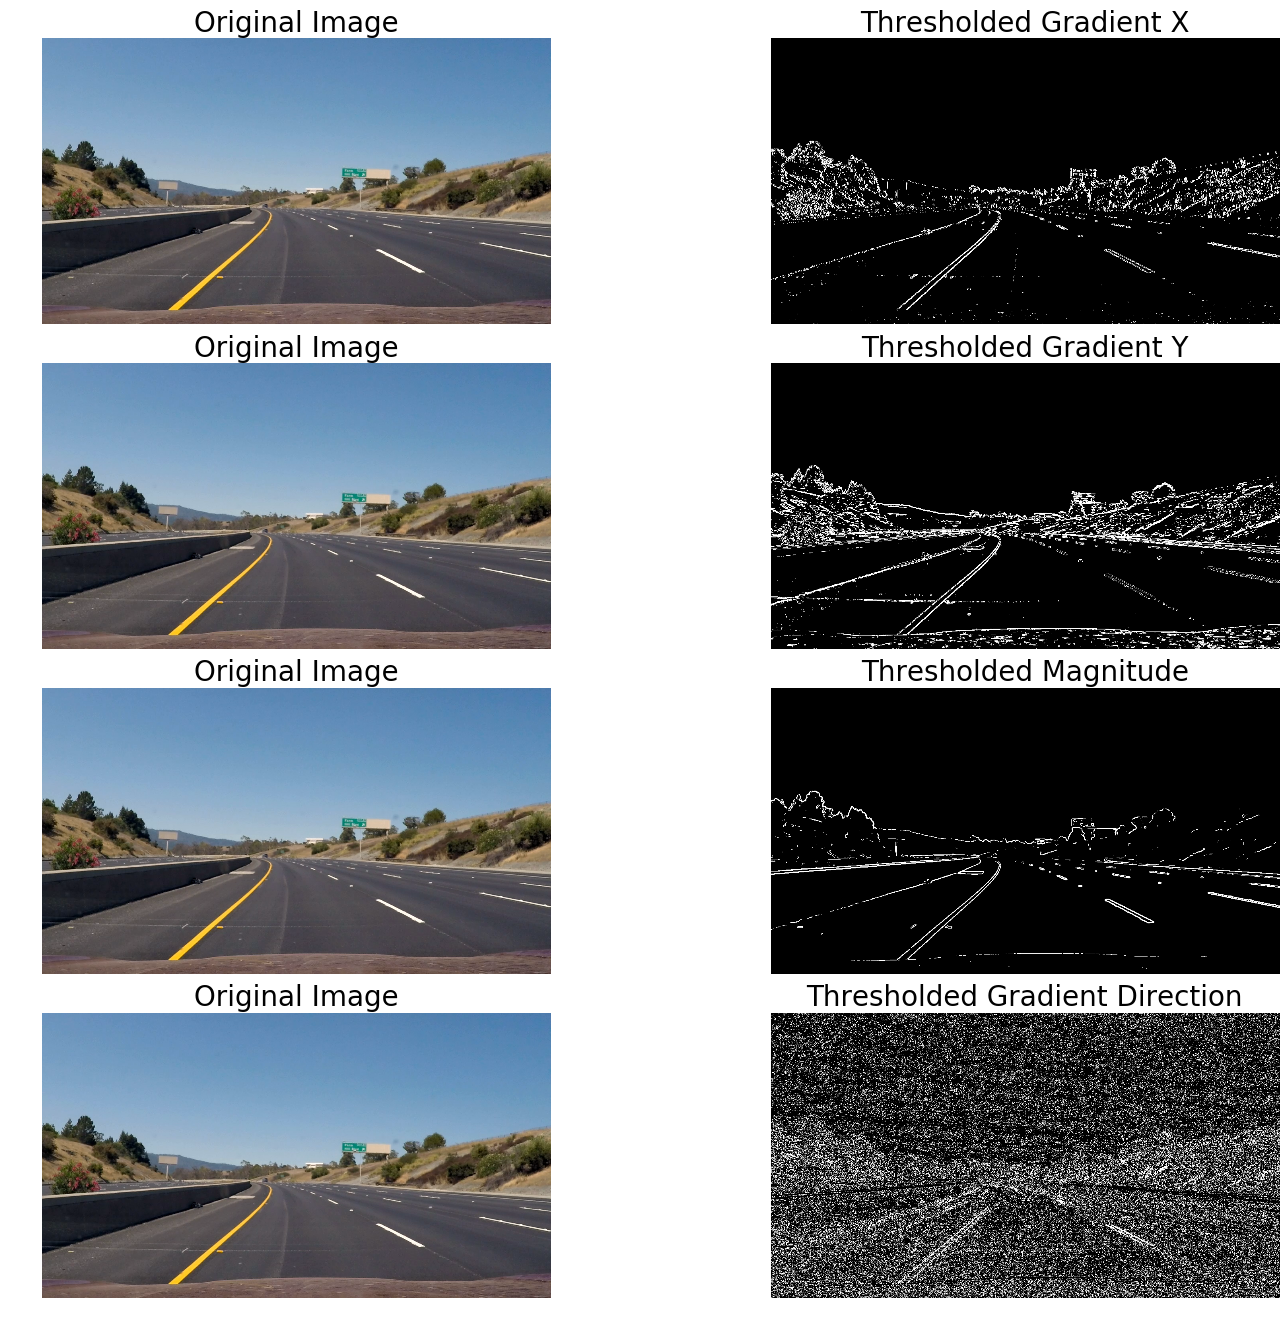

In [47]:
# Run the function
image = frame1
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(75, 255))
dir_binary = dir_threshold(image, sobel_kernel=3, thresh=(0.8, 1.3))


# Plot the result
axs = []
f, axs = plt.subplots(4, 2, figsize=(14, 14))
f.tight_layout()

axs[0][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][0].axis("off");
axs[0][1].imshow(grad_binary_x, cmap='gray')
axs[0][1].set_title('Thresholded Gradient X', fontsize=20)
axs[0][1].axis("off");

axs[1][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[1][0].set_title('Original Image', fontsize=20)
axs[1][0].axis("off");
axs[1][1].imshow(grad_binary_y, cmap='gray')
axs[1][1].set_title('Thresholded Gradient Y', fontsize=20)
axs[1][1].axis("off");

axs[2][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[2][0].set_title('Original Image', fontsize=20)
axs[2][0].axis("off");
axs[2][1].imshow(mag_binary, cmap='gray')
axs[2][1].set_title('Thresholded Magnitude', fontsize=20)
axs[2][1].axis("off");

axs[3][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[3][0].set_title('Original Image', fontsize=20)
axs[3][0].axis("off");
axs[3][1].imshow(dir_binary, cmap='gray')
axs[3][1].set_title('Thresholded Gradient Direction', fontsize=20)
axs[3][1].axis("off");
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Threshold

(-0.5, 1279.5, 719.5, -0.5)

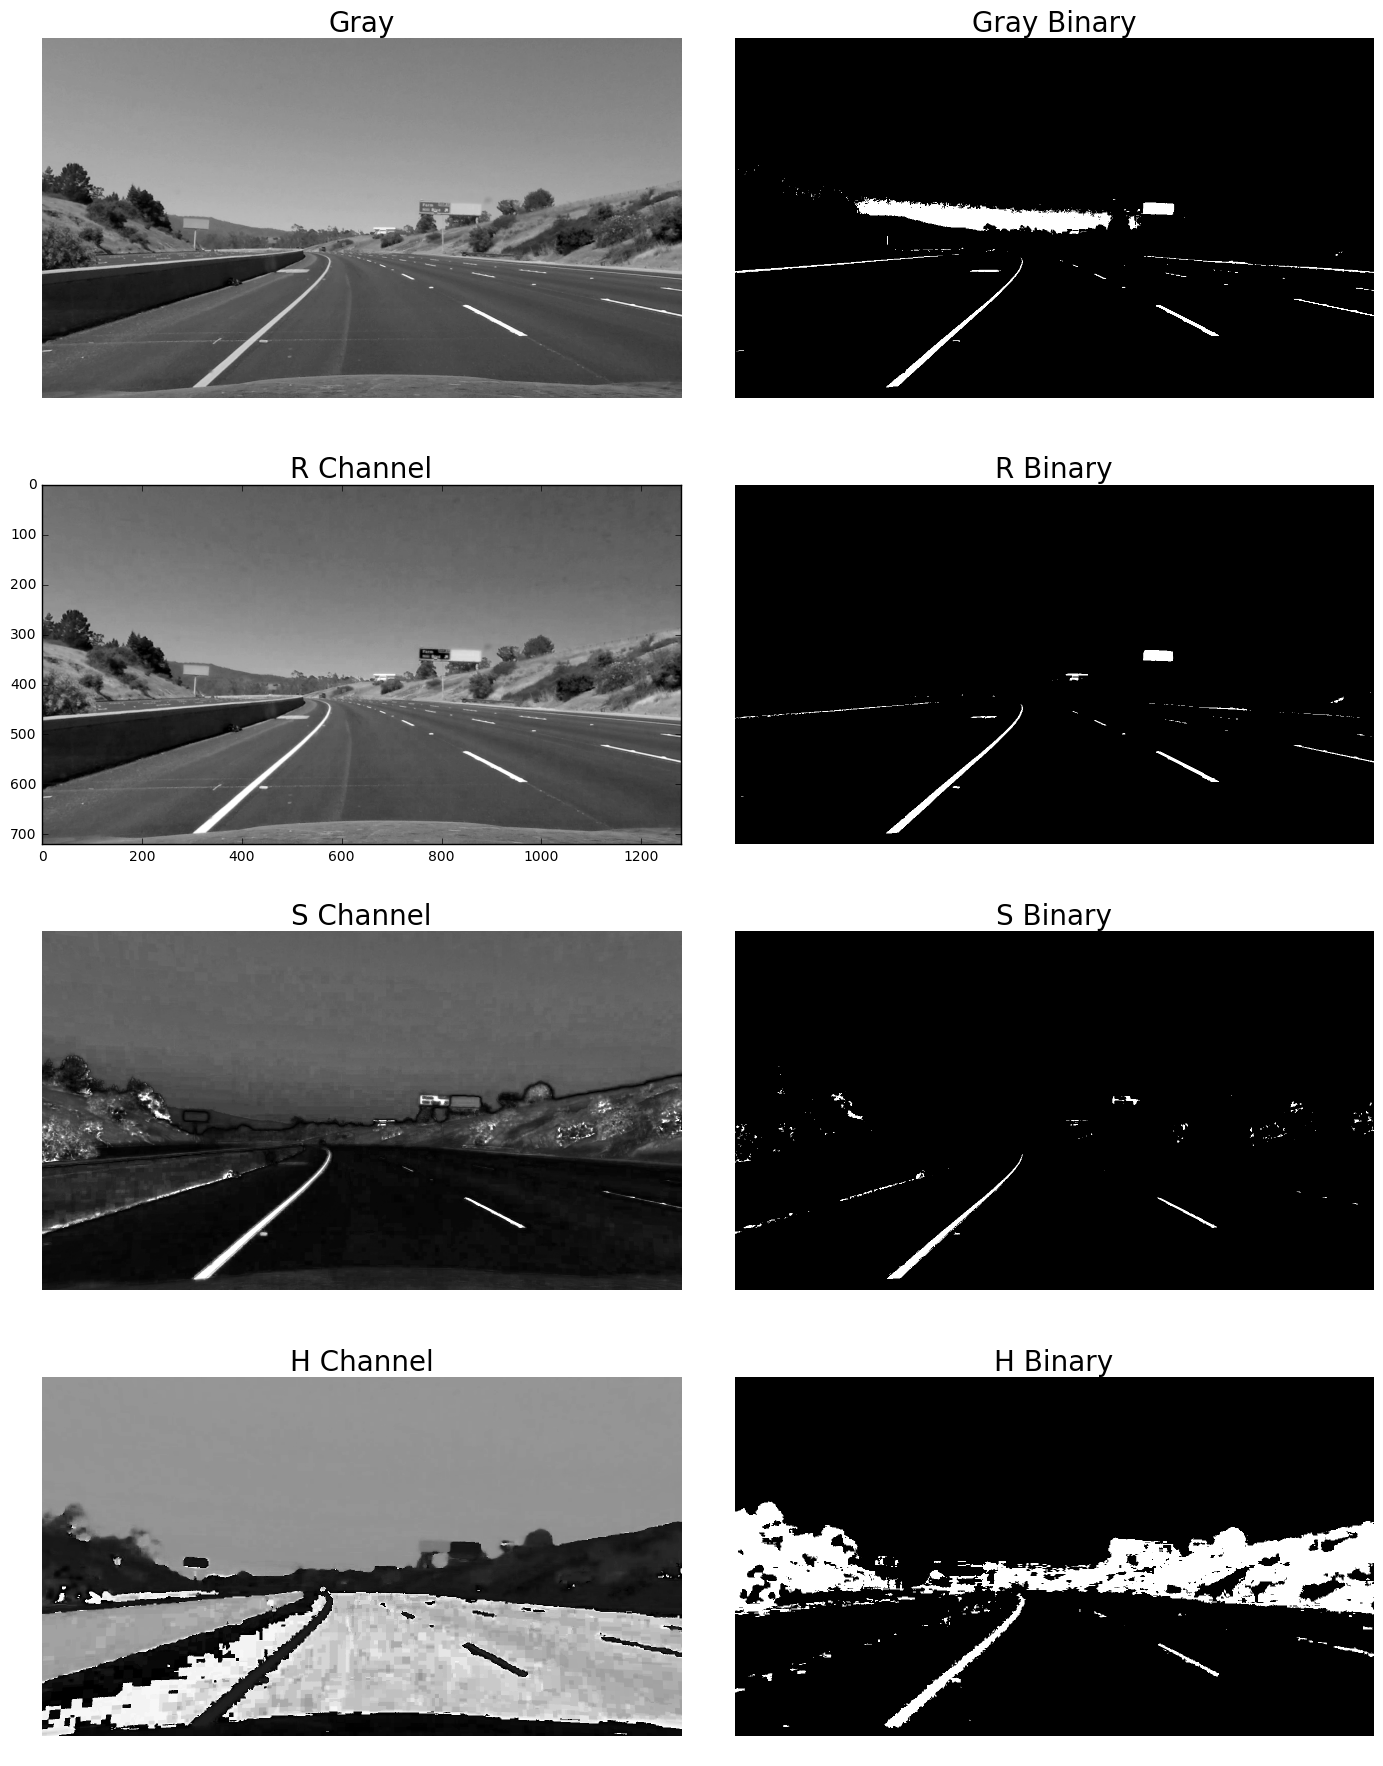

In [48]:
# NOTE: this function does not account for all possibilities of color_space and channel, only those used in this project
def color_thresh(img, color_space = 'hls', channel = 's', vis = True, thresh=(180,255)):
    binary = None
    channel_img = img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    
    if color_space == 'gray':
        #thresh = (180, 255)
        binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
        if vis:
            channel_img = gray

    if color_space == 'rgb':
        #thresh = (180, 255)
        binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
        R = img[:,:,0]
        G = img[:,:,1]
        B = img[:,:,2]
        if channel == 'r':
            thresh = (200, 255)
            binary = np.zeros_like(R)
            binary[(R > thresh[0]) & (R <= thresh[1])] = 1
            if vis:
                channel_img = R
    elif color_space == 'hls':
        #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        if channel == 's':
            #thresh = (90, 255)
            binary = np.zeros_like(S)
            binary[(S > thresh[0]) & (S <= thresh[1])] = 1

            if vis:
                channel_img = S
        if channel == 'h':
            thresh = (15, 100)
            binary = np.zeros_like(H)
            binary[(H > thresh[0]) & (H <= thresh[1])] = 1
            if vis:
                channel_img = H

    return binary, channel_img     
        
    
    
gray_binary, gray = color_thresh(frame1_undistorted, color_space = 'gray', channel = '')
r_binary, R = color_thresh(frame1_undistorted, color_space = 'rgb', channel = 'r')
s_binary, S = color_thresh(frame1_undistorted, color_space = 'hls', channel = 's')
h_binary, H = color_thresh(frame1_undistorted, color_space = 'hls', channel = 'h')

f, axs = plt.subplots(4, 2, figsize=(14, 18))
f.tight_layout()
axs[0][0].imshow(gray, cmap='gray')
axs[0][0].set_title('Gray', fontsize=20)
axs[0][0].axis("off")
axs[0][1].imshow(gray_binary, cmap='gray')
axs[0][1].set_title('Gray Binary', fontsize=20)
axs[0][1].axis("off")

axs[1][0].imshow(R, cmap='gray')
axs[1][0].set_title('R Channel', fontsize=20)
axs[0][0].axis("off")
axs[1][1].imshow(r_binary, cmap='gray')
axs[1][1].set_title('R Binary', fontsize=20)
axs[1][1].axis("off")

axs[2][0].imshow(S, cmap='gray')
axs[2][0].set_title('S Channel', fontsize=20)
axs[2][0].axis("off")
axs[2][1].imshow(s_binary, cmap='gray')
axs[2][1].set_title('S Binary', fontsize=20)
axs[2][1].axis("off")

axs[3][0].imshow(H, cmap='gray')
axs[3][0].set_title('H Channel', fontsize=20)
axs[3][0].axis("off")
axs[3][1].imshow(h_binary, cmap='gray')
axs[3][1].set_title('H Binary', fontsize=20)
axs[3][1].axis("off")

In the output of the above cell we have our original image on the left and the resulting transforms on the right. At first glance the magnitude threshold looks it does the best job of identifying the lane lines with little noise. This is due to the fact that the magnitude threshold considers both Sobel X and Sobel Y. 

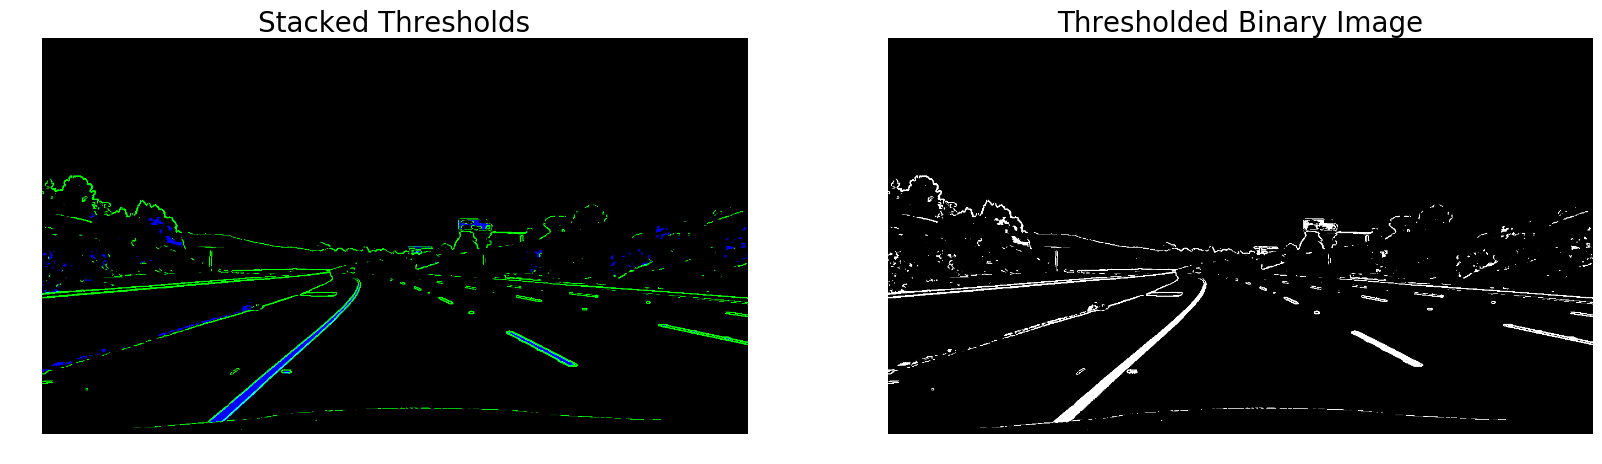

In [49]:
def thresholded_binary(undistorted_img):
    # Magnitude Threshold
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=5, mag_thresh=(75, 255))
    
    # Convert to HLS color space and separate the S channel
    s_binary, s_channel = color_thresh(undistorted_img, color_space = 'hls', channel = 's', vis = True, thresh=(170,255))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(mag_binary), mag_binary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1) | (mag_binary == 1)] = 1

    return color_binary, combined_binary

img = frame1
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = undistort_image(img, objpoints, imgpoints)
color_binary, combined_binary = thresholded_binary(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked Thresholds", fontsize = 20)
ax1.imshow(color_binary)
ax1.axis("off");

ax2.set_title("Thresholded Binary Image", fontsize = 20)
ax2.imshow(combined_binary, cmap="gray")
ax2.axis("off");

# save as file
#binary = 255 * combined_binary.astype("uint8")
cv2.imwrite("output_images/color_binary.jpg", color_binary);
cv2.imwrite("output_images/combined_binary.jpg", combined_binary);

## Perspective Transform
---

In [50]:
def warp_image(img, src, dst, image_size):
  
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

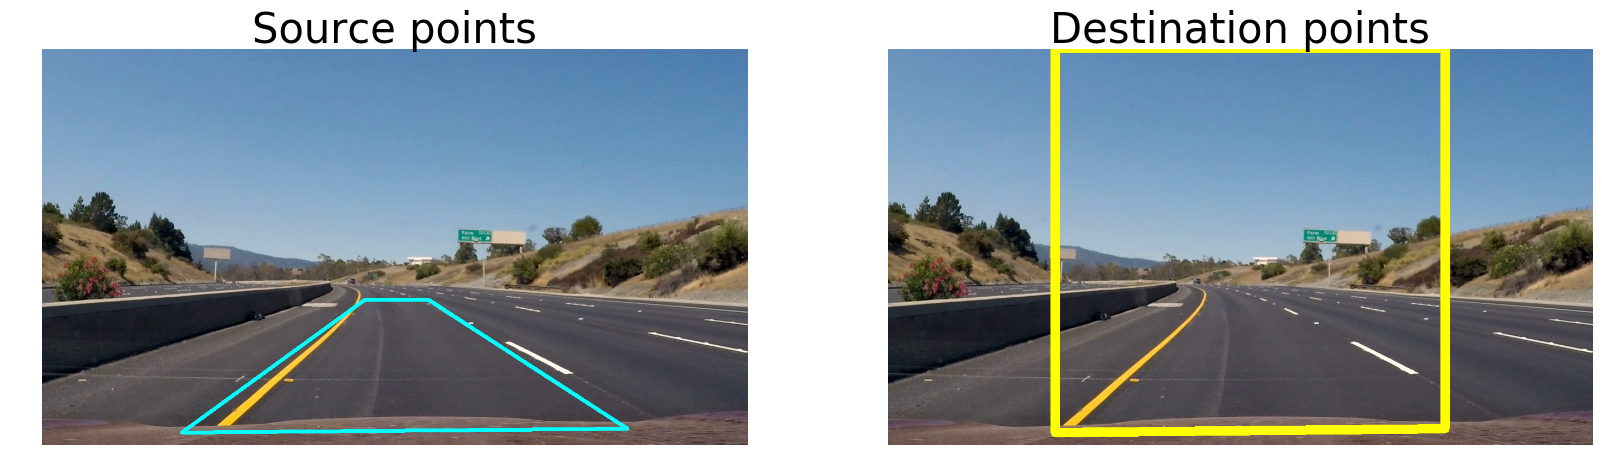

In [51]:
def get_src_dest_warp_points(image):

    # Construct source and destination points as the basis for the perspective transform
    center_point = np.uint(image.shape[1]/2)
    y_top = np.uint(image.shape[0]/1.5)
    
    #x_top_left = center_point - .25*np.uint(image.shape[1]/2) + 50
    #x_top_right = center_point + .25*np.uint(image.shape[1]/2) - 50
    #x_bottom_left = center_point - 1*np.uint(image.shape[1]/2) + 150
    #y_bottom_left = np.uint(image.shape[0])
    #x_bottom_right = np.uint(image.shape[1]) - 150
    
    
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    
    return src, dst


image = frame1
src, dst = get_src_dest_warp_points(image)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 255), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points", fontsize = 30)
plt.axis("off")
#write_image(points_image_src, "output_images/source_points.jpg")

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 255, 0), thickness=15)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points", fontsize = 30)
plt.axis("off")
cv2.imwrite("output_images/source_points.jpg", points_image_src);
cv2.imwrite("output_images/destinatioin_points.jpg", points_image_dst);

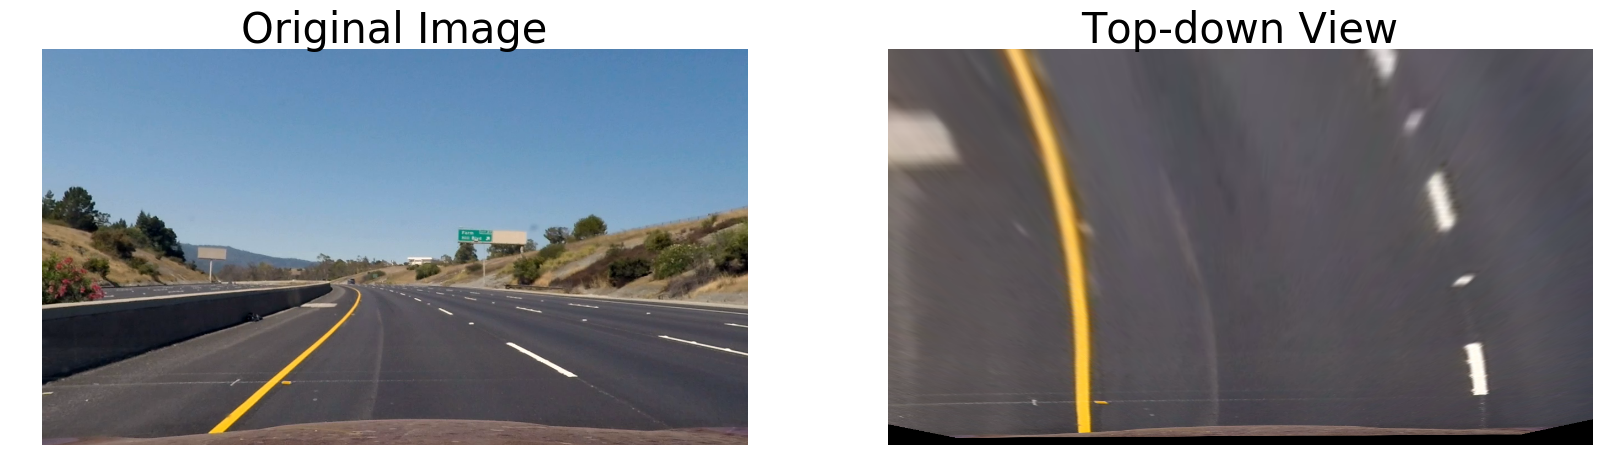

In [52]:
# Read in the same test image as used above and plot
image = frame1_undistorted

src, dst = get_src_dest_warp_points(image)
warped, _, _ = warp_image(image, src, dst, (image.shape[1], image.shape[0]))
#write_image(warped, "output_images/warped_test_straight.jpg")


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Original Image", fontsize = 30)
ax1.imshow(image)
ax1.axis("off");

ax2.set_title("Top-down View", fontsize = 30)
ax2.imshow(warped)
plt.axis("off");
cv2.imwrite("output_images/frame1_topdown.jpg", points_image_dst);

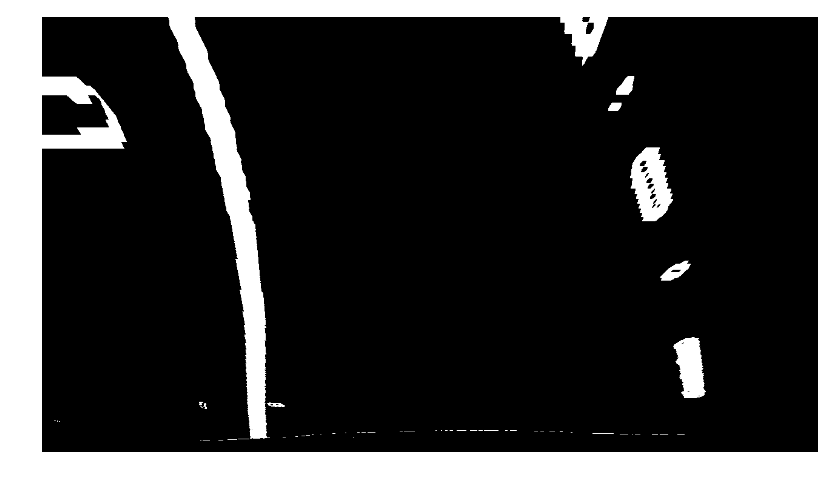

In [53]:
binary_warped, _, Minv = warp_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(10,10))
plt.imshow(binary_warped, cmap = 'gray')
plt.axis("off")

# save as file
binary = 255 * binary_warped.astype("uint8")
cv2.imwrite("output_images/binary_warped.jpg", binary_warped);

## Finding Lanes

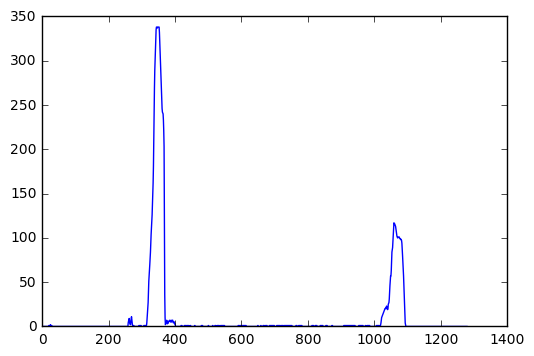

In [54]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [55]:
def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation

In [56]:
def find_lane_lines(binary_warped, debug=False):
    
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r, d = get_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d

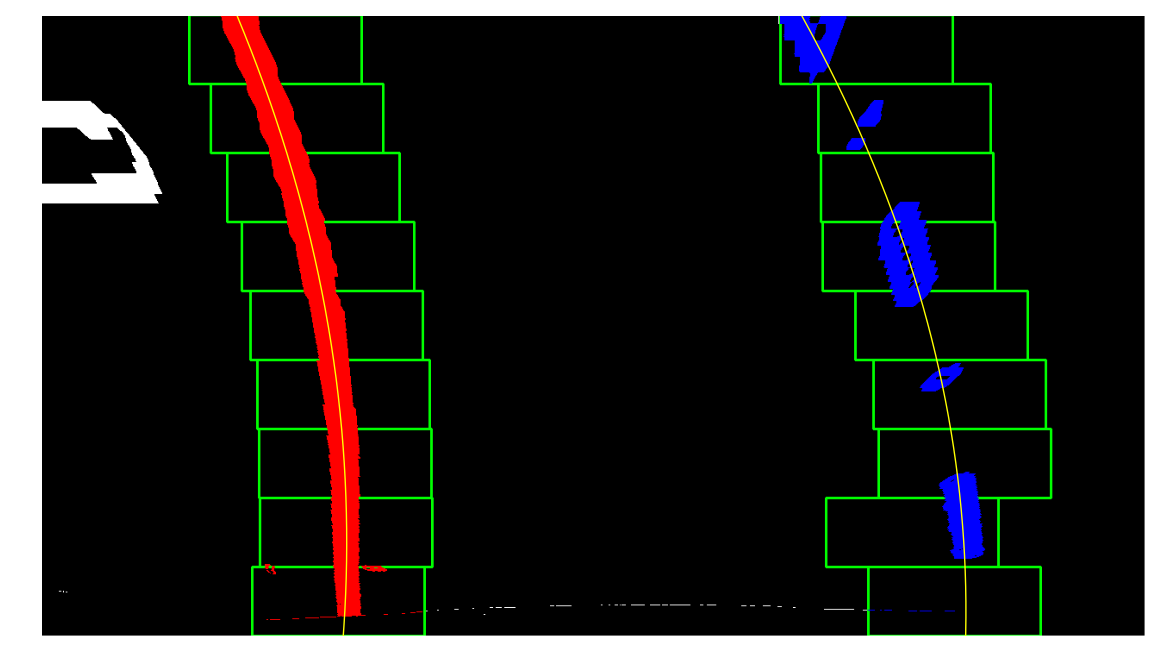

In [57]:
left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img = find_lane_lines(binary_warped, debug=True)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

In [58]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

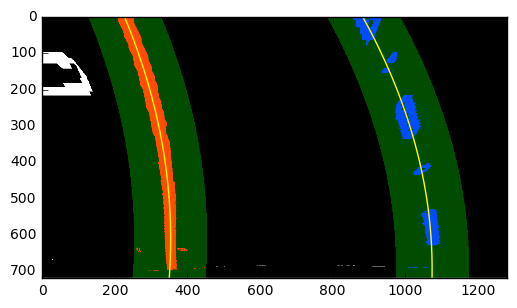

In [59]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

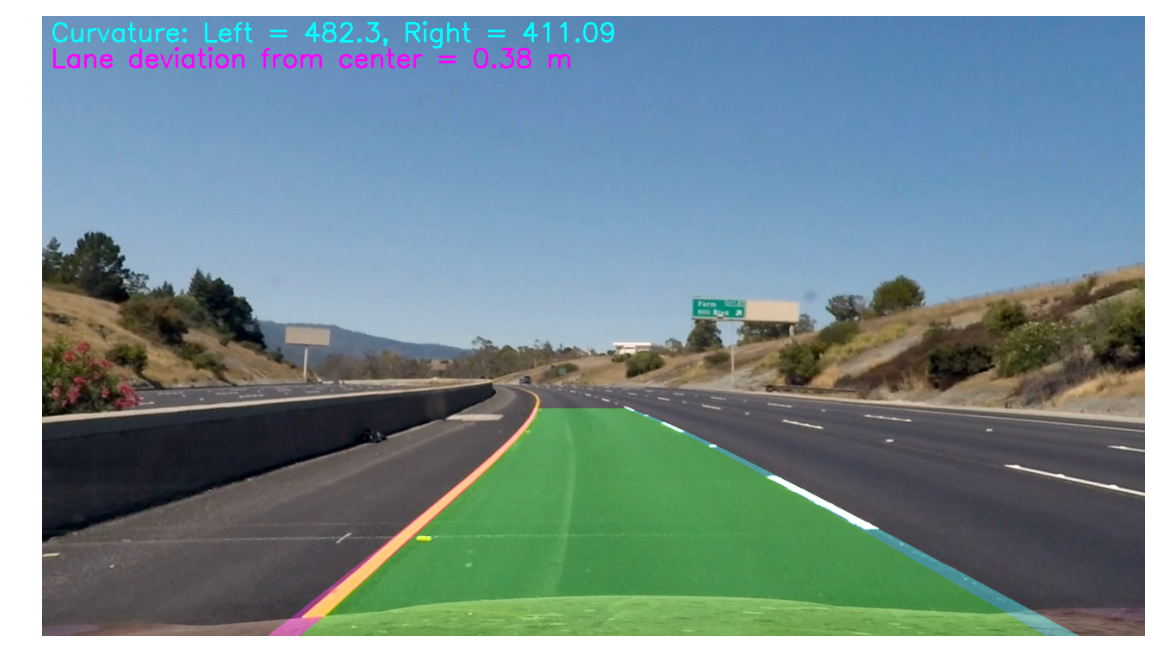

In [60]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=30)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=30)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, curvature_text, (10, 30), font, 1, (0,255,255), 2)
    
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation)   
    cv2.putText(result, deviation_text, (10, 60), font, 1, (255,0,255), 2)
        
    return result

result = draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");
cv2.imwrite("output_images/result.jpg", result);

In [61]:
def process_image(img):
    
    # Undistort Image
    img = img_undistorted = undistort_image(img, objpoints, imgpoints)
    
    # Apply thresholds to image
    _, img = thresholded_binary(img)
    
    # Get source and destination points
    src, dst = get_src_dest_warp_points(img)
    
    # Warp image to get top down view
    img, _, Minv = warp_image(img, src, dst, (image.shape[1], image.shape[0]))
    
    # Find lane lines
    left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d = find_lane_lines(img, debug=False)
    
    # Draw lanes
    img = draw_lanes_on_image(img, img_undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)

    return img

In [24]:
video_challenge_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [20:19<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 24min 5s, sys: 1min 54s, total: 26min
Wall time: 20min 21s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_images/project_video_output.mp4"))